# Overview



In [93]:
#Core imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#regular expressions 
import re

#most common words
from collections import Counter 


[nltk_data] Downloading package stopwords to /Users/joyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
#Import data

data = pd.read_csv('../ads/Advertisement_Transcripts.csv')

In [83]:
#explore data
data.info()

#5 columns with 1,9935 enties 
#the label column is blank and will be dropped for exploration 
#Key data is the Ad_copy column however the Category will be interesting to explore in relation to bias score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         1935 non-null   object 
 1   Advertiser       1935 non-null   object 
 2   Product_or_spot  1935 non-null   object 
 3   Ad_copy          1935 non-null   object 
 4   label            0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 75.8+ KB


In [84]:
#Checking for blank rows 

# Show blank rows
blank_rows = data[data.isnull().all(axis=1)]
print("Blank rows:\n", blank_rows)

# Drop all blank rows
data.dropna(how='all', inplace=True)

print("Number of rows after removing blank rows:", len(data))


Blank rows:
      Category Advertiser Product_or_spot Ad_copy  label
1935      NaN        NaN             NaN     NaN    NaN
Number of rows after removing blank rows: 1935


In [85]:
# Check for duplicates in the 'Ad_copy' column
duplicate_count = data.duplicated(subset=['Ad_copy']).sum()
print(f"There are {duplicate_count} duplicates in the 'Ad_copy' column.")

# Remove duplicates from the 'Ad_copy' column
data.drop_duplicates(subset=['Ad_copy'], inplace=True)

# Print the updated number of duplicates
updated_duplicate_count = data.duplicated(subset=['Ad_copy']).sum()
print(f"Now there are {updated_duplicate_count} duplicates in the 'Ad_copy' column.")


There are 26 duplicates in the 'Ad_copy' column.
Now there are 0 duplicates in the 'Ad_copy' column.


In [86]:
#Explore groups
category_counts = data['Category'].value_counts()

print('Category counts:\n', category_counts)


Category counts:
 Automotive               281
Food & Beverage          242
Home & Personal Care     213
Travel                   191
Advocacy                 153
Financial                141
Beauty                   101
Services                  98
Health Care               73
Media & Entertainment     73
Alcohol & Spirits         64
Restaurants               51
Retail                    47
Insurance                 43
Telecommunications        42
Education                 24
Electronics               16
Technology                13
Sports                    12
Residential               11
Political                  8
Agricultural               5
Appliances                 5
HeaLth Care                2
Name: Category, dtype: int64


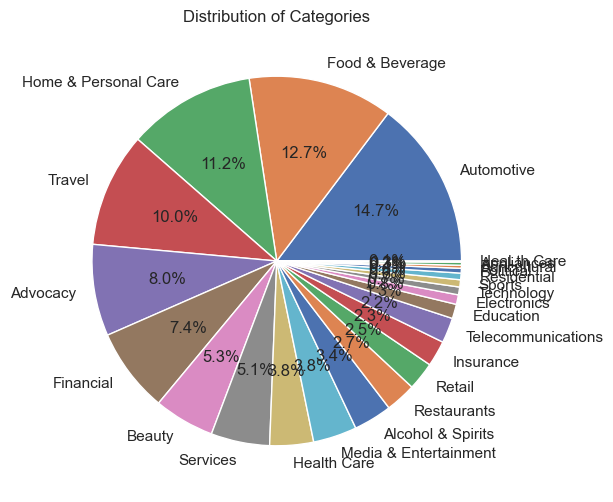

In [87]:
#Visual look at Categories 

sns.set_style('whitegrid')
plt.figure(figsize=(6, 6))
plt.title('Distribution of Categories')
sns.color_palette('pastel')
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.show()

#the smaller percentage not visible 

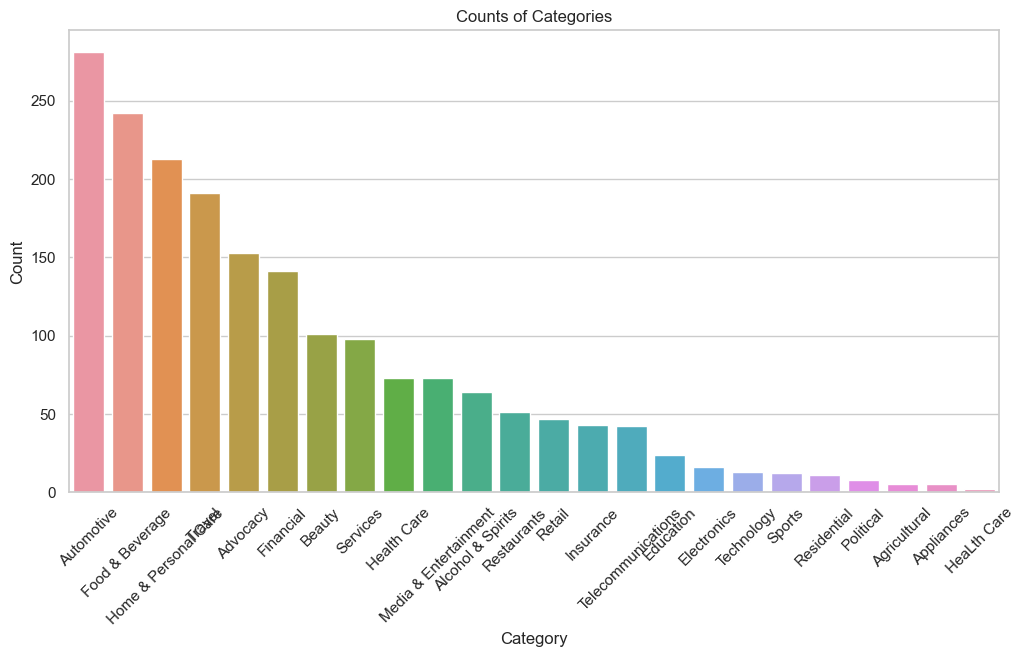

In [88]:
#Display in bar chart 

sns.set(style="whitegrid")

category_counts = data['Category'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)


plt.title("Counts of Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)  


plt.show()


Cleaning Data
- Drop columns not needed
- Add new column for clean data
- Remove special charters and number √®
- convert to all lower case 
- Remove quotation marks ""
- Remove number phone numbers and price 7707937550
- remove website 
- Newline \n
- Stop words but keep the genered pronouns

In [89]:
#Checking for other options that would need to be removed 

random_sample = data.sample(n=5)[['Ad_copy']]

display(random_sample)


,Ad_copy
1682,Let's say you are at a race track and you want to put money on a horse. Which horse are you going to bet on? A run of the mill Kentucky Trotter or a State of the Art Robot horse that flies at the speed of sound and shoots laser beams out of its eyes? The new Super X Computers are the Robot horses of the computer derby which gives you 21st century access to Cyber Space and the wider world of WEB and HTML.
287,"As a little girl you wanted a pony. How about 320 horses? Your ride begins with a sunroof so generous, even second-row passengers can bask in the sun. And with a commanding V8, you and six friends are in for one feisty gallop. Cadillac SRX V8"
1008,"You're dedicated. You're out there doing it. The other key: a nutrition program that helps access stored body fat to help you lose weight, perform better, and look more fit. A diet with a 40/30/30 ratio of calories from carbohydrates, proteins and fats can help produce great results. That's what the PR BAR and our 40/30/30 FASTBURN program are all about. Call us and get started on a program that helps get results. 1-800-397-5556. It's all about results."
1197,"22,000 dentists think enough of Crest White Strips to sell them in their offices. 15 million people have already tried them. 4 out of 5 will recommend them. Crest White Strips. The secret to a whiter smile is in the strip. Guaranteed."
992,"Grillers of America? Here's a little secret that'll add more thrill to your grill. Pam for Grilling.\nIt's specially formulated for your grill's high temperatures, so food won't stick and clean-up's a snap. Fire up your grill with Pam for Grilling. Another reason Pam is America's favorite no-stick cooking spray."


In [91]:
# Drop unnecessary columns
columns_to_drop = ['label', 'Advertiser', 'Product_or_spot']

for column in columns_to_drop:
    if column in data.columns:
        data.drop(columns=column, inplace=True)


data.head(1)

,Category,Ad_copy
0,Advocacy,"Women make up seventy percent of the labor force in Uganda, yet rarely get the chance to bring their own products to market. 23 Women is a real story of real women who saw the need to join together, work hard, and deliver the best coffee their country could offer.\nRated the number one coffee in Uganda at the AFCA Taste of Harvest Competition, these women produce some of the best coffee in the world."


In [94]:
#Cleaning and pre-processing data

# Remove gendered pronouns from the stop words set as this is needed for the testing
gendered_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself'}
stop_words = stop_words.difference(gendered_pronouns)



def clean_text(text):
    # Remove special characters, numbers, and quotation marks
    cleaned_text = re.sub(r"[^a-zA-Z'\s]", " ", text)

    # Convert the text to lowercase
    cleaned_text = cleaned_text.lower()

    # Remove phone numbers and prices
    cleaned_text = re.sub(r"\b\d{5,}\b", "", cleaned_text)

    # Remove website URLs
    cleaned_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*'(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", cleaned_text)

    # Replace newline characters with spaces
    cleaned_text = cleaned_text.replace("\n", " ")

    # Remove stopwords while keeping gendered pronouns
    words = cleaned_text.split()
    words = [word for word in words if word not in stop_words]
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the cleaning function to the new column
data['clean_copy'] = data['Ad_copy'].apply(clean_text)

In [110]:
#Checking data
random_sample = data.sample(n=5)[['clean_copy']]

display(random_sample)

,clean_copy
1095,hours hair want could say boyfriend physique styling sprays guarantee full hours fabulous hair f...
468,analog instrumentation leather wrapped steering wheel contoured sport bucket seats new pontiac g...
649,box without service box hp people hp superdome becomes solution instead server service comprehen...
1748,join us extraordinary journey along one america's greatest rivers explore region's historic cult...
1642,children right appropriate early reading instruction based individual needs international readin...


In [115]:
#Number of words in clean_copy
data['word_count'] = data['clean_copy'].apply(lambda x: len(str(x).split()))
random_sample = data.sample(n=5)

display(random_sample)

,Category,Ad_copy,clean_copy,word_count
1096,Health Care,"Plavix could help make a difference, so ask your doctor about adding plavix. Taken with aspirin ...",plavix could help make difference ask doctor adding plavix taken aspirin current treatment plavi...,44
526,Beauty,Illuminate! Shine! Glow! With new Condition finishing shine. Special lightweight ingredients giv...,illuminate shine glow new condition finishing shine special lightweight ingredients give hair mu...,35
99,Advocacy,You're the kind of parent who would do anything for your child. And so would we. We're National ...,kind parent would anything child would we're national pta support better education resources saf...,31
659,Electronics,Times have changed. So have batteries. Presenting batteries for the digital age. If you don't ha...,times changed batteries presenting batteries digital age still dark,9
627,Education,We've been developing leaders for 55 years. All you need is 5 days. The critical path to success...,we've developing leaders years need days critical path success begins cornell johnson school exe...,37


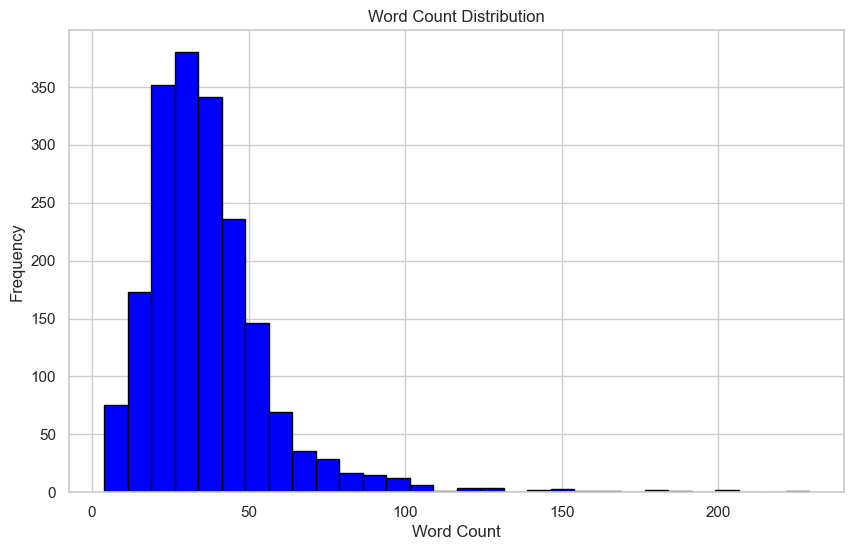

In [104]:
#Plot word count 
plt.figure(figsize=(10, 6))
plt.hist(data['word_count'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

#there seems to be a few extreme on 150+ words

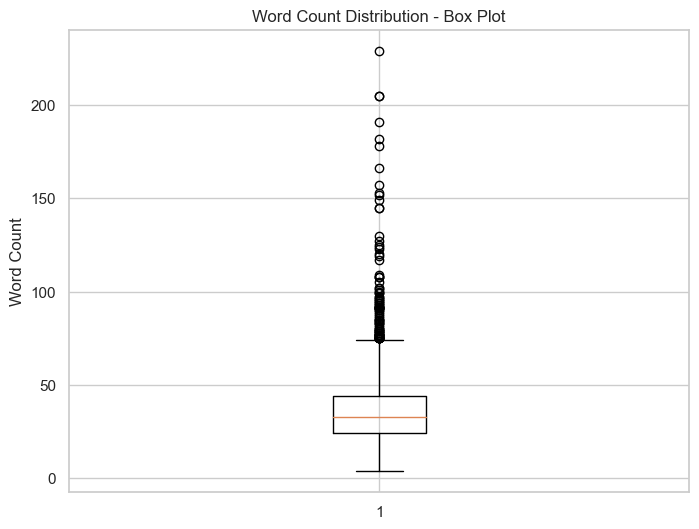

In [105]:

# A box plot of the word count distribution
plt.figure(figsize=(8, 6))
plt.boxplot(data['word_count'])
plt.ylabel('Word Count')
plt.title('Word Count Distribution')
plt.show()


#Not going to remove the outliers as the dataset is already small. Will note this as continue to use the dataset

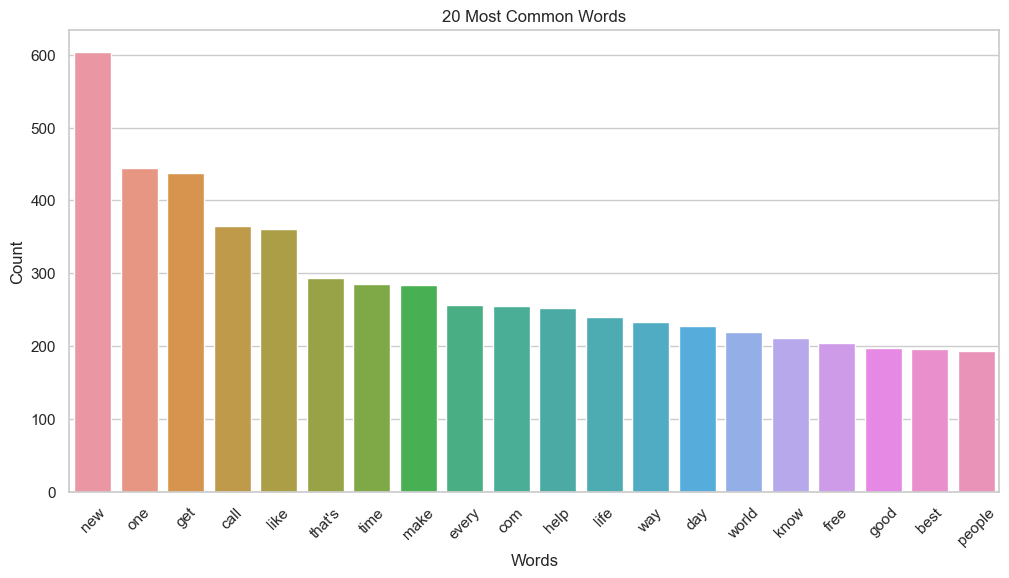

In [129]:
# Most common words 

# All cleaned text into a single string
all_text = ' '.join(data['clean_copy'])

# Split the text into individual words
words = all_text.split()

# Create a Counter object to count the occurrences of each word
word_count = Counter(words)

# Find the 20 most common words
most_common_words = word_count.most_common(20)

# Bar plot
words, counts = zip(*most_common_words)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))

plt.title("20 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [124]:

original_text = ' '.join(data['Ad_copy'])
original_words = original_text.split()
original_word_count = Counter(original_words)
most_common_original_words = original_word_count.most_common(20)

for word, count in most_common_original_words:
    print(f"{word}: {count}")


the: 4114
and: 2999
to: 2862
a: 2765
of: 2209
you: 1879
your: 1518
in: 1285
for: 1277
is: 1112
with: 965
that: 838
on: 684
The: 645
can: 633
it: 621
at: 582
or: 548
from: 518
are: 467


In [126]:
# Compare before and after 

word_comparison_df = pd.DataFrame({
    'Original_Word': [word for word, count in most_common_original_words],
    'Original_Count': [count for word, count in most_common_original_words],
    'Cleaned_Word': [word for word, count in most_common_words],
    'Cleaned_Count': [count for word, count in most_common_words]
})

print(word_comparison_df)

#The word 'com' might need to be remove as it maybe the end of website e.g. home.com > home com

   Original_Word  Original_Count Cleaned_Word  Cleaned_Count
0            the            4114          new            604
1            and            2999          one            445
2             to            2862          get            438
3              a            2765         call            365
4             of            2209         like            361
5            you            1879       that's            294
6           your            1518         time            285
7             in            1285         make            284
8            for            1277        every            256
9             is            1112          com            255
10          with             965         help            252
11          that             838         life            240
12            on             684          way            233
13           The             645          day            227
14           can             633        world            220
15            it        

#Cleaning Data

In [ ]:
#Words mixture of relvent inclusive and non-inclsive words. Words were source from vasious location 



masculine_words = [
    "active",
    "adventurous",
    "aggress",
    "ambitio",
    "analy",
    "assert",
    "athlet",
    "autonom",
    "battle",
    "boast",
    "challeng",
    "champion",
    "compet",
    "confident",
    "courag",
    "decid",
    "decision",
    "decisive",
    "defend",
    "determin",
    "domina",
    "dominant",
    "driven",
    "fearless",
    "fight",
    "force",
    "greedy",
    "head-strong",
    "headstrong",
    "hierarch",
    "hostil",
    "impulsive",
    "independen",
    "individual",
    "intellect",
    "lead",
    "logic",
    "objective",
    "opinion",
    "outspoken",
    "persist",
    "principle",
    "reckless",
    "self-confiden",
    "self-relian",
    "self-sufficien",
    "selfconfiden",
    "selfrelian",
    "selfsufficien",
    "stubborn",
    "superior",
    "unreasonab"
]

feminine_words = [
    "agree",
    "affectionate",
    "child",
    "cheer",
    "collab",
    "commit",
    "communal",
    "compassion",
    "connect",
    "considerate",
    "cooperat",
    "co-operat",
    "depend",
    "emotiona",
    "empath",
    "feel",
    "flatterable",
    "gentle",
    "honest",
    "interpersonal",
    "interdependen",
    "interpersona",
    "inter-personal",
    "inter-dependen",
    "inter-persona",
    "kind",
    "kinship",
    "loyal",
    "modesty",
    "nag",
    "nurtur",
    "pleasant",
    "polite",
    "quiet",
    "respon",
    "sensitiv",
    "submissive",
    "support",
    "sympath",
    "tender",
    "together",
    "trust",
    "understand",
    "warm",
    "whin",
    "enthusias",
    "inclusive",
    "yield",
    "share",
    "sharin"
]

gendered_words = [
    "Actor",
    "Actress",
    "male",
    "man",
    "master",
    "Bogeyman",
    "Boogeyman",
    "Businessman",
    "Businessmen",
    "Chairman",
    "Congressman",
    "Crone",
    "sir"
    "madam",
    "Female",
    "Fireman",
    "Gals",
    "Girl",
    "Girls",
    "Guys",
    "Hag",
    "Housekeeping",
    "Ladies",
    "gentlemen",
    "Ladies room",
    "Lady",
    "Lady time",
    "Ladylike",
    "Mailman",
    "Man hours",
    "Man made",
    "Man up",
    "Mankind",
    "Manpower",
    "Mastered",
    "Mastering",
    "Old geezer",
    "Policeman",
    "Postman",
    "Prostitute",    
    "Skank",    
    "Skanky",    
    "Slut",    
    "Steward",    
    "Stewardess",    
    "Stewardesses",    
    "The common man",    
    "Tramp",    
    "Whore"]

masculine_pronouns = ['he', 'him', 'his', 'himself', 'man', 'men', 'male', 'father', 'brother', 'son', 'uncle', 'grandfather', 'nephew', 'husband', 'boyfriend', 'groom', 'king', 'prince', 'emperor', 'sir', 'lord']

feminine_pronouns = ['she', 'her', 'hers', 'herself', 'woman', 'women', 'female', 'mother', 'sister', 'daughter', 'aunt', 'grandmother', 'niece', 'wife', 'girlfriend', 'bride', 'queen', 'princess', 'empress', 'lady', 'madam']



In [ ]:
# Pick the text 
text = data['Ad_copy'].sample().iloc[0]

# check if any feminine words are in the text
fem_words = [word for word in feminine_words if word in text.lower()]
fem_in_text = len(fem_words)

# check if any masculine words are in the text
masc_words = [word for word in masculine_words if word in text.lower()]
masc_in_text = len(masc_words)

# check if any gendered words are in the text
maspro_words = [word for word in masculine_pronouns if word in text.lower()]
fempro_words = [word for word in feminine_pronouns if word in text.lower()]
gen_in_text = len(maspro_words) + len(fempro_words)

# print the results
print('Feminine words in text:', fem_in_text)
print('Masculine words in text:', masc_in_text)
print('Gendered words in text:', gen_in_text)
print('Pronouns words in text: fem', len(fempro_words), 'male', len(maspro_words))
print('Feminine words found:', fem_words)
print('Masculine words found:', masc_words)
print('Gendered words found:', maspro_words + fempro_words)
print(text)


Version one notes
- It was flag word I could not see in the text. add the the words flagged and found it was picking up parts of words. 
- Thinking: clean filler words and tokenizse text. not sure if steeming needed at this stage 
- I still need to understand the output in order to label it so will add a coloumn to dataset 